In [1]:
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import pydicom
import matplotlib.pyplot as plt

base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
dst_dir = Path('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms')

In [2]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation

 ACR464		   bkg_only	 CTP404_peds    old
 anthropomorphic   CCT189_peds	 metadata.csv  'Sibley Hospital Data'


TODO:

1. take FBP from PediatricCTTSizeDataAugmentation and move to `/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms`

In [3]:
import numpy as np
def age_to_eff_diameter(age):
    # https://www.aapm.org/pubs/reports/rpt_204.pdf
    x = age
    a = 18.788598
    b = 0.19486455
    c = -1.060056
    d = -7.6244784
    y = a + b*x**1.5 + c *x**0.5 + d*np.exp(-x)
    eff_diam = y
    return eff_diam

adult_waist_circumferences_cm = {
    # 20: 90.7,
    30: 99.9,
    40: 102.8,
    # 50: 103.3,
    60: 106.2,
    70: 106.6,
    80: 104.1
}

def diameter_range_from_subgroup(subgroup):
    if subgroup == 'newborn': return (0, age_to_eff_diameter(1/12))
    elif subgroup == 'infant': return (age_to_eff_diameter(1/12), age_to_eff_diameter(2))
    elif subgroup == 'child': return (age_to_eff_diameter(2), age_to_eff_diameter(12))
    elif subgroup == 'adolescent': return (age_to_eff_diameter(12), age_to_eff_diameter(22))
    else: return (age_to_eff_diameter(22), 100)

def pediatric_subgroup(diameter):
    if diameter < age_to_eff_diameter(1):
        return 'newborn'
    elif (diameter >= age_to_eff_diameter(1)) & (diameter < age_to_eff_diameter(5)):
        return 'infant'
    elif (diameter >= age_to_eff_diameter(5)) & (diameter < age_to_eff_diameter(12)):
        return 'child'
    elif (diameter >= age_to_eff_diameter(12)) & (diameter < age_to_eff_diameter(22)):
        return 'adolescent'
    else:
        return 'adult'
    
def subgroup_to_age(group):
    if group == 'newborn': return 1/12
    if group == 'infant': return 2
    if group == 'child': return 12
    if group == 'adolescent': return 21
    if group == 'adult': return 39

In [4]:
meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta.phantom.isin(['MITA-LCD', 'uniform', 'CTP404']) & meta.recon.isin(['fbp']) & meta['Dose [%]'].isin([25, 100])]
meta['kernel']='D45'
meta['scanner']='Siemens Somatom Definition'
meta.pop('Code #')
meta.pop('ethnicity')
meta.pop('weight percentile')
meta.pop('height [cm]')
meta.pop('weight [kg]')
meta.pop('BMI')
meta.pop('gender')
meta['pediatric subgroup'] = meta['effective diameter [cm]'].apply(pediatric_subgroup)
meta['age [year]'] = meta['pediatric subgroup'].apply(subgroup_to_age)
meta.sort_values(by=['phantom', 'effective diameter [cm]', 'Dose [%]'], inplace=True)
meta = meta[['Name', 'effective diameter [cm]', 'age [year]', 'pediatric subgroup', 'phantom', 'scanner', 'Dose [%]', 'recon', 'kernel', 'FOV [cm]', 'file']]
meta

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file
884,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25,fbp,D45,12.3,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
890,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100,fbp,D45,12.3,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
956,13.1 mm CTP404,13.1,0.083333,newborn,CTP404,Siemens Somatom Definition,25,fbp,D45,14.4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
962,13.1 mm CTP404,13.1,0.083333,newborn,CTP404,Siemens Somatom Definition,100,fbp,D45,14.4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
860,15.0 mm CTP404,15.0,0.083333,newborn,CTP404,Siemens Somatom Definition,25,fbp,D45,34.0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
866,15.0 mm CTP404,15.0,0.083333,newborn,CTP404,Siemens Somatom Definition,100,fbp,D45,34.0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
1004,15.1 mm CTP404,15.1,0.083333,newborn,CTP404,Siemens Somatom Definition,25,fbp,D45,16.6,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
1010,15.1 mm CTP404,15.1,0.083333,newborn,CTP404,Siemens Somatom Definition,100,fbp,D45,16.6,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
908,18.5 mm CTP404,18.5,2.000000,infant,CTP404,Siemens Somatom Definition,25,fbp,D45,20.4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...
914,18.5 mm CTP404,18.5,2.000000,infant,CTP404,Siemens Somatom Definition,100,fbp,D45,20.4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...


Filter down to MITA-LCD, uniform and CTP404 described in the [RST description](https://fda-my.sharepoint.com/:w:/g/personal/brandon_nelson_fda_gov/ERUfskjNMcRLstJ5EaF3YWcBnlnbGEgLgNFOdAhosq9MoQ?e=iyccun) and fbp

In [5]:
img = sitk.ReadImage(meta.file.iloc[0])
vol = sitk.GetArrayFromImage(img)
vol.shape

(19, 512, 512)

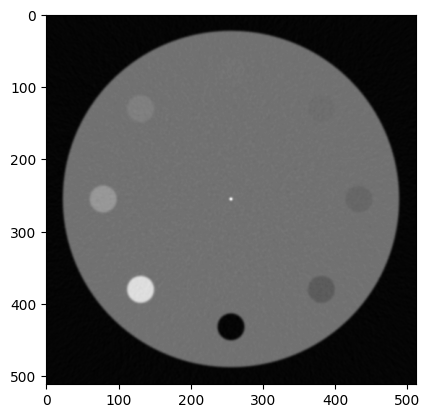

In [6]:
plt.imshow(vol[0], cmap='gray')

## Organize Dataset

In [7]:
from pydicom import dcmread
from datetime import datetime
from pydicom.data import get_testdata_file

def get_ground_truth(fname):
    fname = Path(fname)
    if fname.stem.startswith('signal'):
        gt_file = 'noise_free.mhd'
        return Path(fname).parents[2] / gt_file
    if fname.stem.startswith('ACR464'):
        gt_file = 'true.mhd'
        return Path(fname).parents[3] / gt_file
    else:
        gt_file = 'true.mhd'
        return Path(fname).parents[2] / gt_file
    
def write_series_to_dicom(series, save_dir):
    # load default dicom file
    fpath = get_testdata_file("CT_small.dcm")
    ds = dcmread(fpath)
    # update meta info
    ds.Manufacturer = 'Siemens (simulated)'
    ds.ManufacturerModelName = 'Definition AS+ (simulated)'

    time = datetime.now()
    ds.InstanceCreationDate = time.strftime('%Y%m%d')
    ds.InstanceCreationTime = time.strftime('%H%M%S')
    ds.InstitutionName = 'FDA/CDRH/OSEL/DIDSR'
    ds.StudyDate = ds.InstanceCreationDate
    ds.StudyTime = ds.InstanceCreationTime
    ds.StudyDescription = 'Pediatric IQ Phantoms'
    age = series['age [year]']
    if not age >= 1:
        age = 0
    ds.PatientName = series.phantom
    ds.SeriesInstanceUID = str(series.name)
    ds.PatientAge = f'{int(age):03d}Y'
    ds.PatientID = str(series.name)
    del(ds.PatientWeight)
    ds.ImageComments = f"effctive diameter [cm]: {series['effective diameter [cm]']}"
    if not series['Dose [%]']:
        ds.ImageComments += ' ground truth'
        series.Name+='_groundtruth'
    ds.ScanOptions = 'AXIAL MODE'
    ds.ReconstructionDiameter = series['FOV [cm]'] * 10
    ds.ConvolutionKernel ='fbp D45'
    ds.Exposure = series['Dose [%]']

    # load image data
    if series['Dose [%]']:
        img = sitk.ReadImage(series.file)
    else:
        img = sitk.ReadImage(get_ground_truth(series.file)) 
    vol = sitk.GetArrayFromImage(img)
    if vol.ndim == 2: vol = vol[None]
    
    ds.Rows, ds.Columns = img.GetHeight(), img.GetWidth()
    ds.SliceThickness = img.GetSpacing()[-1]
    ds.SpacingBetweenSlices = ds.SliceThickness
    ds.PixelSpacing = list(img.GetSpacing()[:2])
    ds.KVP = 120
    
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)
    
    # saveout slices as individual dicom files
    fnames = []
    for slice_idx, array_slice in enumerate(vol):
        ds.SliceLocation = -img.GetDepth()//2*ds.SliceThickness + slice_idx*ds.SliceThickness
        ds.ImagePositionPatient[-1] = ds.SliceLocation
        ds.PixelData = array_slice.astype('int16') - int(ds.RescaleIntercept)
        if series['Dose [%]']:
            fname = save_dir / f"{series.Name}_{slice_idx:03d}.dcm"
        else:
            fname = save_dir.parents[1] / f"{series.Name}_{slice_idx:03d}.dcm"
        fnames.append(fname)
        pydicom.write_file(fname, ds)
    return fnames

In [8]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter112mm

dose_010  dose_040  dose_070  dose_100	 true.mhd
dose_025  dose_055  dose_085  dose_1000  true.raw


In [9]:
from tqdm import tqdm
from shutil import rmtree

save_dir = Path('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms')

overwrite=False
if overwrite & save_dir.exists():
    rmtree(save_dir)

    df_list = []
    for idx, series in tqdm(meta.iterrows(), total=len(meta)):
        phantom = series.phantom
        diameter = series['effective diameter [cm]']
        dose = series['Dose [%]']
        recon = series.recon
        save_subdir = save_dir / phantom / f'diameter_{int(10*diameter):03d}mm' / f'dose_{dose:03d}' / recon
        fnames = write_series_to_dicom(series, save_subdir)
        temp_df = pd.concat(len(fnames)*[pd.DataFrame(series).T], ignore_index=True)
        temp_df['repeat']=list(map(lambda o: int(o.stem.split('_')[-1]), fnames)) # get repeat number from filename
        temp_df['file']=fnames
        df_list.append(temp_df)
        # add ground truth
        series['Dose [%]']=None
        fnames = write_series_to_dicom(series, save_subdir)
        temp_df = pd.concat(len(fnames)*[pd.DataFrame(series).T], ignore_index=True)
        temp_df['repeat']=list(map(lambda o: int(o.stem.split('_')[-1]), fnames)) # get repeat number from filename
        temp_df['file']=fnames
        df_list.append(temp_df)
    out_meta = pd.concat(df_list, ignore_index=True)
    out_meta.loc[out_meta['Dose [%]'].isna(), 'recon'] = 'ground truth'
    out_meta.loc[out_meta['Dose [%]'].isna(), 'kernel'] = None
    out_meta = out_meta[~out_meta.duplicated()]
    out_meta.to_csv(save_dir/'metadata.csv', index=False)

## move noise free to pediatricCT size

In [10]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/

diameter112mm  diameter150mm  diameter185mm  diameter292mm  metadata.csv
diameter131mm  diameter151mm  diameter216mm  diameter350mm


In [11]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/

diameter112mm  diameter185mm  diameter292mm	ground_truth.raw
diameter131mm  diameter200mm  diameter350mm	metadata.csv
diameter151mm  diameter216mm  ground_truth.mhd	summary.csv


In [12]:
!ls /gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CCT189/monochromatic/diameter112mm/

geometry_info.csv     I0_0075000	    I0_0255000_processed
I0_0010000	      I0_0075000_processed  I0_0300000
I0_0010000_processed  I0_0085000	    I0_0300000_processed
I0_0025000	      I0_0085000_processed  image_geometry.png
I0_0025000_processed  I0_0100000	    image_info.csv
I0_0030000	      I0_0100000_processed  noise_free_bkg.raw
I0_0030000_processed  I0_0120000	    noise_free_disk.raw
I0_0040000	      I0_0120000_processed  phantom_info_mm.csv
I0_0040000_processed  I0_0165000	    phantom_info_pix_idx.csv
I0_0055000	      I0_0165000_processed  true_bkg.raw
I0_0055000_processed  I0_0210000	    true_disk.raw
I0_0070000	      I0_0210000_processed
I0_0070000_processed  I0_0255000


## Viewing Images

In [13]:
from pathlib import Path
import pandas as pd
base_dir = Path('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms')
metadata = pd.read_csv(base_dir / 'metadata.csv')
metadata

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,repeat
0,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,0
1,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,1
2,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,2
3,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,3
4,11.2 mm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6731,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,100.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,195
6732,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,100.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,196
6733,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,100.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,197
6734,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,100.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,198


In [14]:
sorted(metadata['FOV [cm]'].unique())

[12.0,
 12.3,
 14.0,
 14.4,
 16.6,
 17.0,
 20.0,
 20.4,
 23.8,
 24.0,
 32.0,
 32.1,
 34.0,
 38.5,
 39.0]

In [15]:
row = metadata[(metadata['phantom'] == 'CTP404') &
               (metadata['recon'] == 'ground truth') &
               (metadata['FOV [cm]'] == 32.1) &
               (metadata['repeat'] == 0)]
row

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,repeat
259,29.2 mm CTP404_groundtruth,29.2,21.0,adolescent,CTP404,Siemens Somatom Definition,NaN,ground truth,NaN,32.1,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,0


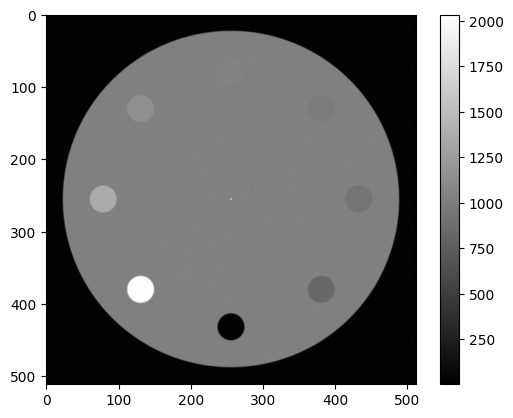

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,repeat
260,29.2 mm CTP404,29.2,21.0,adolescent,CTP404,Siemens Somatom Definition,100.0,fbp,D45,32.1,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,0


In [16]:
import matplotlib.pyplot as plt

row = metadata[(metadata['Dose [%]']==100) &
               (metadata['phantom'] == 'CTP404') &
               (metadata['recon'] == 'fbp') &
               (metadata['kernel'] == 'D45') &
               (metadata['FOV [cm]'] == 32.1) &
               (metadata['repeat'] == 0)]
dcm_file = row.file.item()
dcm = pydicom.dcmread(dcm_file)
img = dcm.pixel_array
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()
row

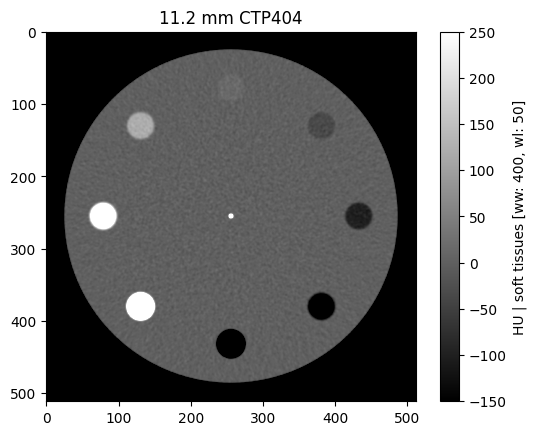

In [17]:
from utils import browse_studies
browse_studies(metadata, phantom='CTP404', fov=12.3, dose=100, recon='fbp', kernel='D45', repeat=0, display='soft tissues')

In [18]:
from utils import study_viewer

In [19]:
study_viewer(metadata)

interactive(children=(Dropdown(description='phantom', options=('CTP404', 'MITA-LCD', 'uniform'), value='CTP404…